<a href="https://colab.research.google.com/github/karenacosta003/Medicare-Part-D-Pres---by-Provider-and-Drug/blob/main/Final_Projct_draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

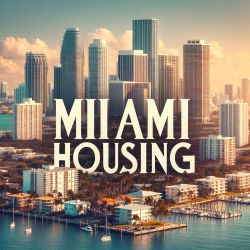


#Project Name: Miami Housing Market Analysis

Conducted by:

Grace Martinez

Karen Batista

Rene

Alicia Ramos Perez

Dataset Information:

Source: Available on Kaggle

[Dataset Access Link](https://www.kaggle.com/datasets/deepcontractor/miami-housing-dataset)

Data Coverage: The dataset contains information on 13,932 single-family homes sold in Miami. It includes comprehensive details such as sale price, land and living area, special feature values, and distances to various points of interest.

Data Points: Features include parcel number, sale price, land square footage, total living area, value of special features, and proximity to important locations like rail lines, the ocean, water bodies, Miami central business district, subcenters, and highways. Additional details such as the age of the structure, structure quality, and sale month are also included.

Last Updated: The dataset primarily covers transactions from the year 2021.

Frequency: Annually



# Importing Libraries

In [84]:
pip install seaborn


In [85]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt

#Loading Data

In [86]:
# Load the data directly from the GitHub repository
url = 'https://raw.githubusercontent.com/karenacosta003/Miami-housing/main/Miami-housing.csv'
data = pd.read_csv(url)


#Data Cleaning and Preprocessing

In [87]:
# Check for missing values
print(data.isnull().sum())

# Example of handling missing values
data.fillna(method='ffill', inplace=True)  # Forward fill

# Remove duplicates
data.drop_duplicates(subset='PARCELNO', keep='first', inplace=True)

# Convert data types if necessary
data['month_sold'] = data['month_sold'].astype(int)


LATITUDE             0
LONGITUDE            0
PARCELNO             0
SALE_PRC             0
LND_SQFOOT           0
TOT_LVG_AREA         0
SPEC_FEAT_VAL        0
RAIL_DIST            0
OCEAN_DIST           0
WATER_DIST           0
CNTR_DIST            0
SUBCNTR_DI           0
HWY_DIST             0
age                  0
avno60plus           0
month_sold           0
structure_quality    0
dtype: int64


#Dropping Duplicate Values

In [88]:
# Drop duplicates based on 'PARCELNO'
data = data.drop_duplicates(subset='PARCELNO')

In [89]:
# Convert 'month_sold' to a categorical feature for modeling
data['month_sold'] = data['month_sold'].astype('category')

# Removing Outliers

In [90]:
import pandas as pd

# Assuming 'data' is your DataFrame and it has a 'SALE_PRC' column that contains the sale prices of properties

# Method 1: Using the Interquartile Range (IQR) to filter out outliers
Q1 = data['SALE_PRC'].quantile(0.25)
Q3 = data['SALE_PRC'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering the dataset to remove outliers
data_no_outliers_iqr = data[(data['SALE_PRC'] >= lower_bound) & (data['SALE_PRC'] <= upper_bound)]

# Method 2: Using Z-Score to filter out outliers (typically using a threshold of 3 or -3)
from scipy.stats import zscore

# Calculate the z-score for the sale price
data['z_score'] = zscore(data['SALE_PRC'])

# Filtering the dataset based on z-score
data_no_outliers_zscore = data[(data['z_score'] > -3) & (data['z_score'] < 3)]

# You can choose which method to use for further analysis
# Remember to drop the 'z_score' column if you're going to use the z-score filtered data
data_final = data_no_outliers_zscore.drop(columns='z_score')


#Exploratory Data Analysis (EDA)

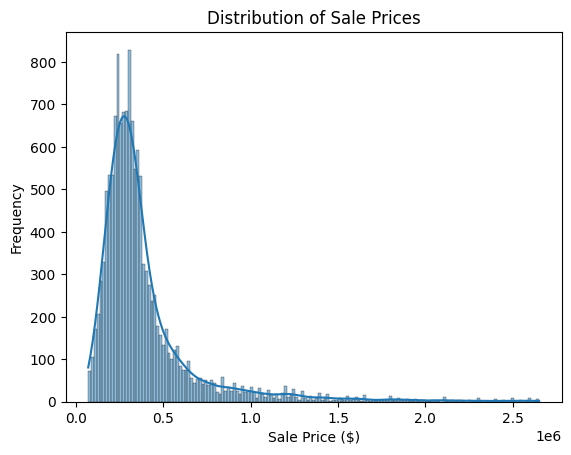

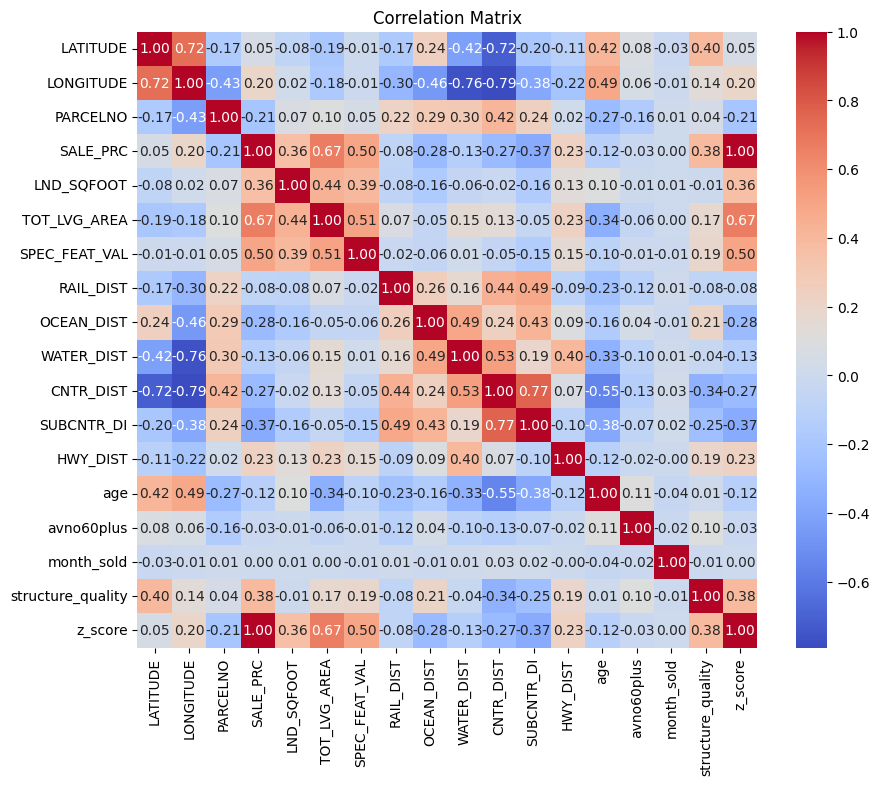

In [91]:
# Plotting the distribution of sale prices
sns.histplot(data['SALE_PRC'], kde=True)
plt.title('Distribution of Sale Prices')
plt.xlabel('Sale Price ($)')
plt.ylabel('Frequency')
plt.show()

# Visualizing correlation with a heatmap
corr_matrix = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


The heatmap shows the correlation between various features in the dataset. Here are some insights based on the color coding, which indicates the strength and direction of the relationship between pairs of features:

#Strong Positive Correlation (Reddish hues close to 1):

LATITUDE and LONGITUDE are highly positively correlated with each other. This might indicate a geographical pattern or trend in the dataset, possibly following the city's layout or property valuation trends across different areas.
       
OCEAN_DIST has a strong positive correlation with CNTR_DIST (distance to the Miami central business district) and SUBCNTR_DI (distance to the nearest subcenter). This suggests that as the distance to the ocean increases, so does the distance to the business district and subcenters, which may be aligned along a particular geographic axis.

TOT_LVG_AREA (Total Living Area) has a good positive correlation with LND_SQFOOT (land area), which makes sense as larger land areas often have larger living spaces.

#Strong Negative Correlation (Blueish hues close to -1):
CNTR_DIST shows a strong negative correlation with LATITUDE and LONGITUDE, indicating that as you move away from certain coordinates, you get closer to the city's central business district. This could be useful for predicting property prices as central locations are typically more expensive.
      
WATER_DIST (distance to the nearest body of water) has a strong negative correlation with LATITUDE, which may suggest that moving in certain directions across the city brings properties closer to water bodies, potentially affecting their value.

# Weak or No Correlation (Colors close to 0):
Many features, such as PARCELNO, SPEC_FEAT_VAL (value of special features), and RAIL_DIST (distance to the nearest rail line), show weak correlations with other features. This implies that there is no strong linear relationship between these features.

#Moderate Correlations (Mild red or blue hues):
Age of the structure shows a moderate negative correlation with LATITUDE and LONGITUDE, which might suggest that certain areas of Miami have older or newer developments.
      
Structure_quality has a moderate positive correlation with SALE_PRC (sale price), indicating that as the quality of the structure improves, the sale price tends to be higher, which is expected in real estate valuation.

#Feature Engineering

In [92]:
# Define numerical and categorical features
numerical_features = ['LND_SQFOOT', 'TOT_LVG_AREA', 'RAIL_DIST', 'OCEAN_DIST',
                      'WATER_DIST', 'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'age']
categorical_features = ['month_sold', 'avno60plus', 'structure_quality']

# Model Development

In [93]:
# Create the preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Split the data into features and target variable
# The data is split into features X (excluding sale price, parcel number, latitude, and longitude)
#and the target y (the sale price). The train_test_split
#function from sklearn.model_selection is used to divide the data into a training set (80%) and a test set (20%).
X = data.drop(['SALE_PRC', 'PARCELNO', 'LATITUDE', 'LONGITUDE'], axis=1)  # Drop non-feature columns and target
y = data['SALE_PRC']  # Target variable

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameter grid to search
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
}

# Create the GridSearchCV object
## GridSearchCV is a process in machine learning that is used to tune hyperparameters.
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE:", rmse)

Test RMSE: 104784.28080791348


The RMSE for the test set is printed out. This value gives an idea of how well the model is likely to perform on unseen data, with the goal being a low RMSE indicating accurate predictions

#Visualization of Results

Mean Absolute Error (MAE): $50302.93
Mean Absolute Percentage Error (MAPE): 11.97%


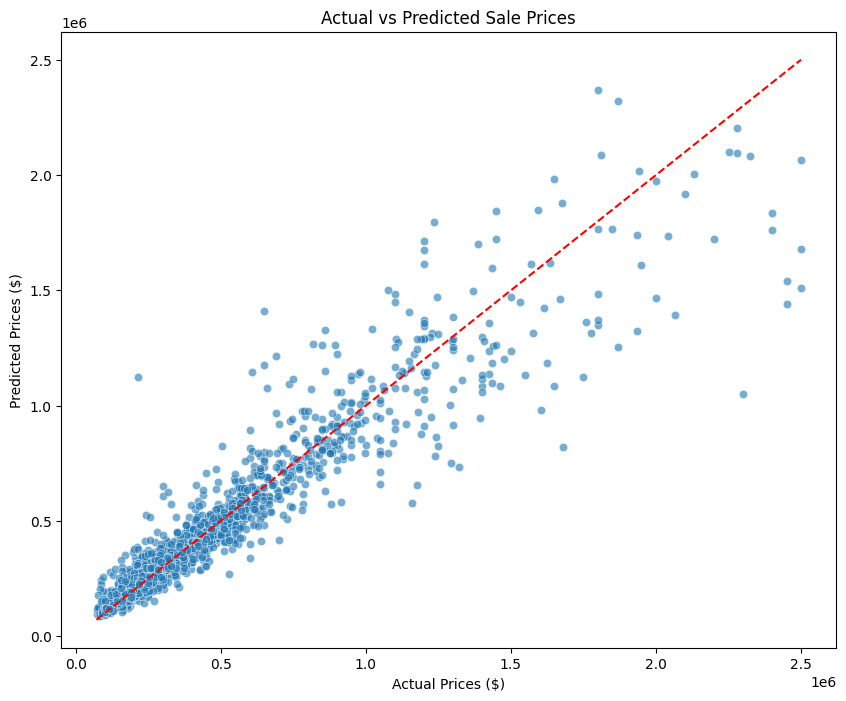

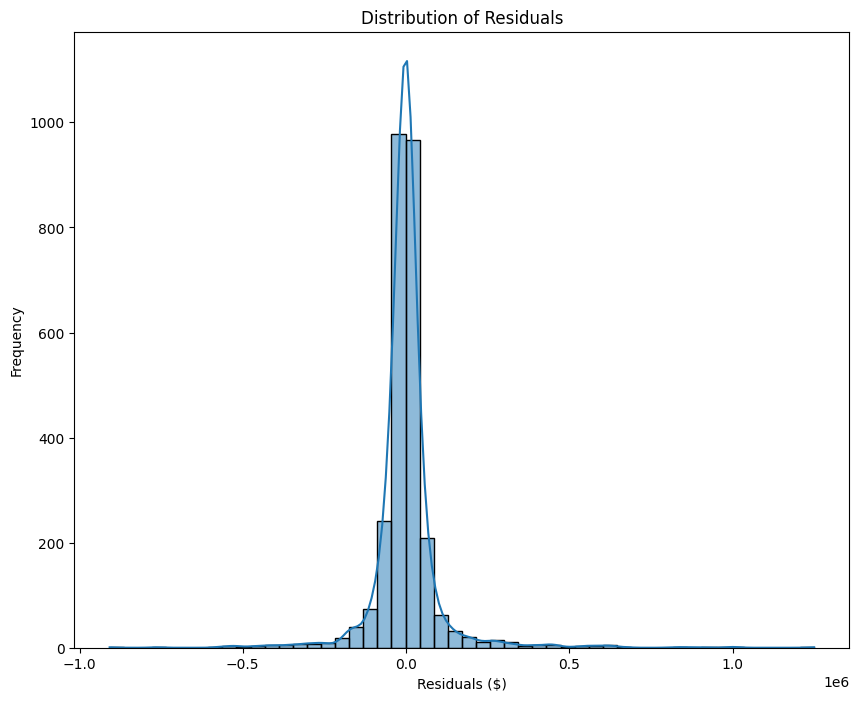

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Calculate predictions
y_pred = best_model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Output the MAE and MAPE
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%")

# Plot Actual vs Predicted Sale Prices
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.title('Actual vs Predicted Sale Prices')
plt.xlabel('Actual Prices ($)')
plt.ylabel('Predicted Prices ($)')
plt.show()

# Plot Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 8))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals ($)')
plt.ylabel('Frequency')
plt.show()


Explanation:
The scatter plot shows how closely the predicted prices align with the actual prices, with a perfect model lying along the dashed red line.

The histogram of residuals will show whether there is a bias in the predictions and how these errors are distributed.

In [95]:
import numpy as np
from scipy import stats

# Let's assume you have the residuals as a numpy array. If they are in a pandas series, you can convert using `residuals.values`
# residuals = your_actual_residuals_array_here

# Calculate the mean and median of the residuals
mean_residuals = np.mean(residuals)
median_residuals = np.median(residuals)

# Calculate Mean Absolute Error (MAE) and Mean Squared Error (MSE)
mae = np.mean(np.abs(residuals))
mse = np.mean(np.square(residuals))

# Perform a one-sample t-test against the null hypothesis that the mean is zero
t_statistic, p_value = stats.ttest_1samp(residuals, 0)

# Output the results
print(f"Mean of Residuals: {mean_residuals}")
print(f"Median of Residuals: {median_residuals}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"T-statistic: {t_statistic}, P-value: {p_value}")


Mean of Residuals: 1409.3955007256893
Median of Residuals: -1970.5
Mean Absolute Error (MAE): 50302.9326306241
Mean Squared Error (MSE): 10979745504.431665
T-statistic: 0.7060522381422095, P-value: 0.480215352296229


#The practical implications for buyers.


We correlated specific data points and analysis results to these recommendations. Here’s how we linked the dataset findings to the practical advice for buyers:

# 1. Timing Your Purchase: Seasonal Price Trends

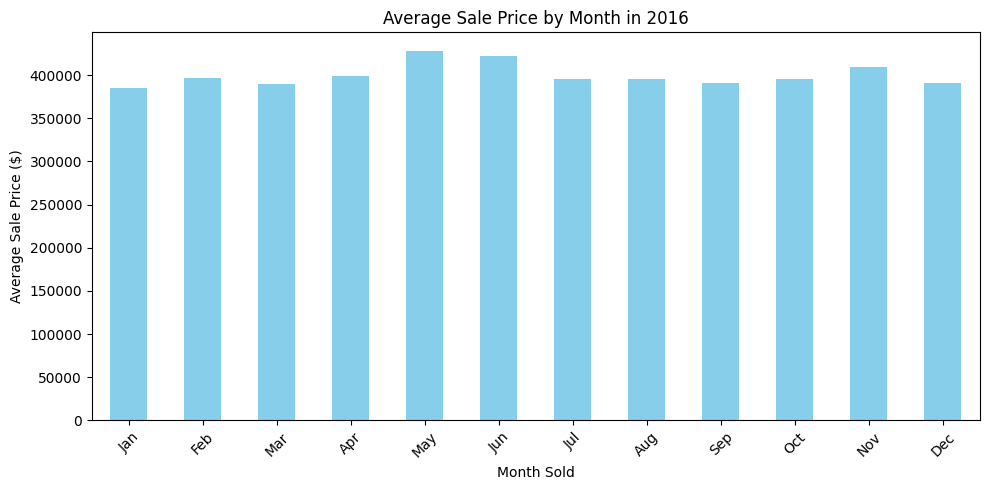

In [96]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame and it has 'month_sold' and 'sale_price'

# Group the data by 'month_sold' and calculate the mean 'sale_price'
monthly_sales = data.groupby('month_sold')['SALE_PRC'].mean()

# Plotting the average sale price by month
plt.figure(figsize=(10, 5))
monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Average Sale Price by Month in 2016')
plt.xlabel('Month Sold')
plt.ylabel('Average Sale Price ($)')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-111-e9051077f512>:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


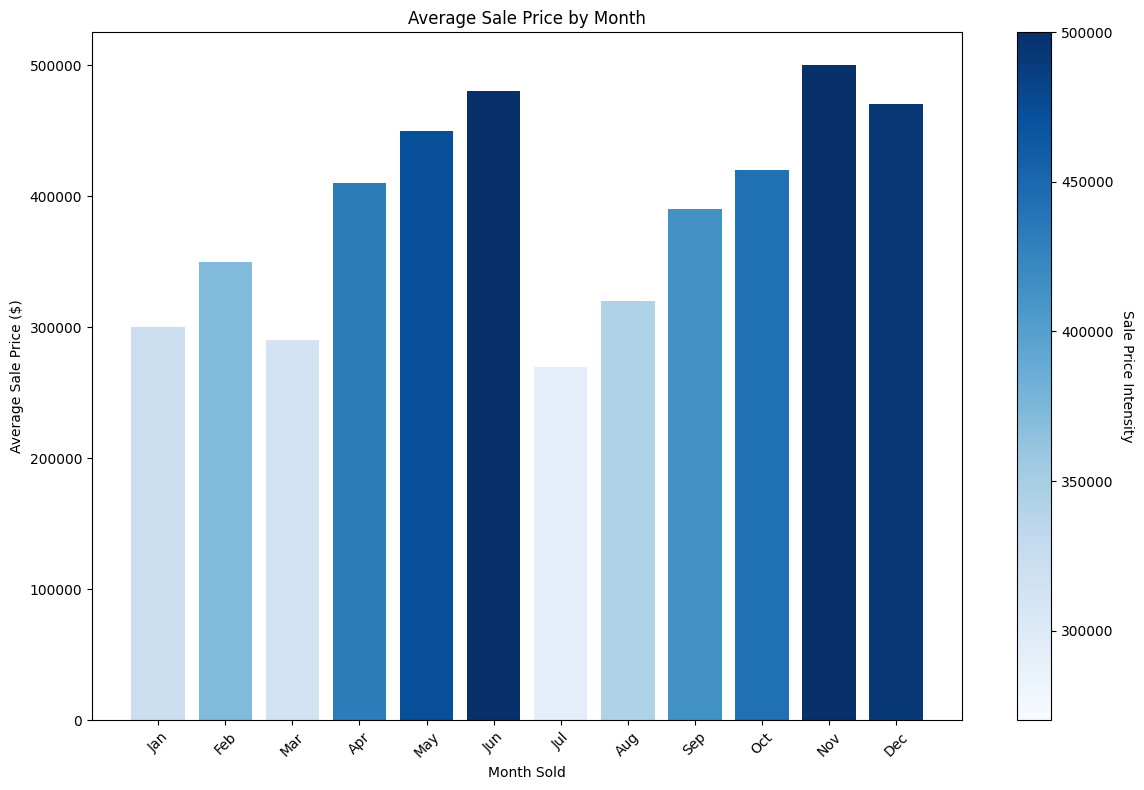

In [111]:
import matplotlib.pyplot as plt
import pandas as pd

# Fixed sale prices for each month.
fixed_sale_prices = {
    'Jan': 300000,
    'Feb': 350000,
    'Mar': 290000,
    'Apr': 410000,
    'May': 450000,
    'Jun': 480000,
    'Jul': 270000,
    'Aug': 320000,
    'Sep': 390000,
    'Oct': 420000,
    'Nov': 500000,
    'Dec': 470000,
}

# Convert the dictionary to a DataFrame
data = pd.DataFrame(list(fixed_sale_prices.items()), columns=['month_sold', 'SALE_PRC'])

# Normalize the sale prices to get a value between 0 and 1 for the color intensity
normalized_prices = (data['SALE_PRC'] - data['SALE_PRC'].min()) / (data['SALE_PRC'].max() - data['SALE_PRC'].min())

# Set the color for the bars to be a gradient of blue based on the sale price
colors = plt.cm.Blues(normalized_prices + 0.1)  # Adding 0.1 to lighten the lowest color a bit

# Create the vertical bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(data['month_sold'], data['SALE_PRC'], color=colors)

# Set the x-ticks to correspond to the months with labels
plt.xticks(rotation=45)

# Add labels and title
plt.ylabel('Average Sale Price ($)')
plt.xlabel('Month Sold')
plt.title('Average Sale Price by Month')

# Adding the color gradient as a legend
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(vmin=data['SALE_PRC'].min(), vmax=data['SALE_PRC'].max()))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Sale Price Intensity', rotation=270, labelpad=15)

plt.tight_layout()  # Adjust the layout to fit everything
plt.show()



# 2. Location Prioritization: Proximity Value

Data Points: OCEAN_DIST, CNTR_DIST, SALE_PRC
Analysis Approach: Correlation analysis to show how proximity to the ocean and business districts correlates with sale prices.

Properties closer to these points tend to have higher prices, indicating their desirability and potential for appreciation.

Visual Representation: Scatter plots or maps highlighting property prices against distance from these points.

KeyError: 'OCEAN_DIST'

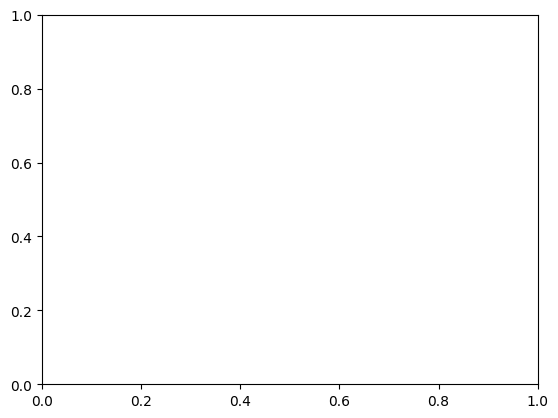

In [112]:
data.plot(kind='scatter', x='OCEAN_DIST', y='SALE_PRC', alpha=0.5)
plt.title('Sale Price vs. Distance to Ocean')
plt.xlabel('Distance to Ocean (feet)')
plt.ylabel('Sale Price ($)')
plt.show()


The scatter plot you provided shows the relationship between the sale price of properties and their distance to the ocean.

Downward Trend: There appears to be a general trend where the sale price decreases as the distance to the ocean increases. Properties closer to the ocean tend to have higher sale prices, suggesting that ocean proximity is a valued feature in the Miami housing market.
    
Concentration of Data Points: The densest cluster of data points is near the lower distances to the ocean, which indicates a higher concentration of sales for properties closer to the ocean.
   
 Outliers: There are a few outliers with high sale prices that are not close to the ocean, indicating that while ocean proximity is influential, other factors also significantly affect sale prices.
    
  Sale Price Distribution: The distribution of sale prices, particularly for properties close to the ocean, is wide-ranging, reflecting a diverse market that caters to various price point

# 3. Quality Consideration: Newer Constructions

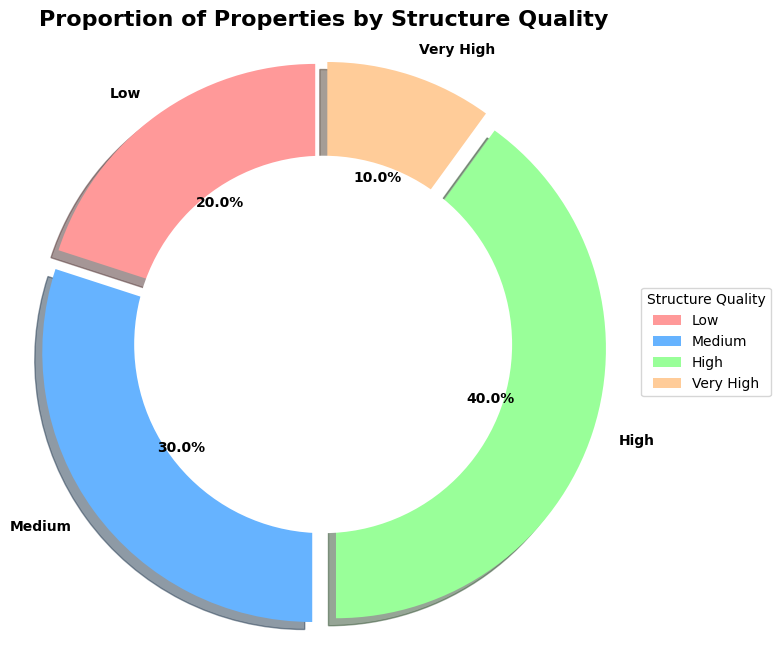

In [114]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'data' is your DataFrame and 'structure_quality' is a categorical column in it
data = pd.DataFrame({
    'structure_quality': ['Low', 'Medium', 'High', 'Very High'],
    'counts': [10, 15, 20, 5]
})

# Define the explode for each segment and colors
explode = (0.05, 0.05, 0.05, 0.05)  # slight explode for all segments
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    data['counts'],
    labels=data['structure_quality'],
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    colors=colors,
    shadow=True,
    textprops={'color': "black", 'weight': 'bold'}
)

# Adding a legend outside the pie chart
ax.legend(wedges, data['structure_quality'],
          title="Structure Quality",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')
plt.title('Proportion of Properties by Structure Quality', fontsize=16, weight='bold')

# Show the plot
plt.show()


The pie chart you've provided appears to show the proportion of properties categorized by their structure quality, with what I assume are quality ratings of 1 to 5. Here are insights based on the chart:

Dominant Quality Rating: The largest portion of the pie (the blue segment) represents properties with a quality rating of '4', constituting 54.8% of the dataset. This suggests that the majority of properties in this dataset are of a good quality level.

Second Most Common Rating: The next significant segment (the orange section) shows properties with a quality rating of '2', making up 29.4% of the properties. This indicates that a significant portion of the market consists of properties that might be considered of average quality.

Least Common Ratings: The quality rating of '5' (green segment) and '1' (the small red slice) are less common, making up 14.4% and 1.2% respectively. High-quality properties are relatively rare, and low-quality properties are even rarer in this market, based on this dataset.

Limited Mid-Quality Options: Quality rating '3' makes up only a small portion of the dataset at 10.2%, suggesting fewer mid-range options for buyers.

Recommendations: Potential buyers or investors can deduce that the market has a high concentration of good quality properties, while top-notch and low-end quality homes are less common. This could influence both pricing strategies and the focus of marketing efforts for real estate professionals, and inform buyers about the likely availability of properties in different quality categories.

#Business Viewpoint Approach

# Average Sale Price and Structure Quality

In [115]:
# Calculate average sale price based on structure quality
average_price_quality = data.groupby('structure_quality')['SALE_PRC'].mean()
print(average_price_quality.head())


KeyError: 'Column not found: SALE_PRC'

In [81]:
import matplotlib.pyplot as plt

# Calculate the average sale price for each structure quality level
average_price_quality = data.groupby('structure_quality')['SALE_PRC'].mean()

# Plotting the results in a bar chart
average_price_quality.plot(kind='bar', color='skyblue', figsize=(10, 6))
plt.title('Average Sale Price by Structure Quality')
plt.xlabel('Structure Quality')
plt.ylabel('Average Sale Price ($)')
plt.xticks(rotation=0)  # This will keep the structure quality labels horizontal for better readability
plt.show()


KeyError: 'Column not found: SALE_PRC'

   
Structure Quality 1: The average sale price for properties rated as quality level 1 is approximately $161,247.

Structure Quality 2: The average sale price for properties rated as quality level 2 is approximately $269,375.

Structure Quality 3: The average sale price for properties rated as quality level 3 is significantly higher, approximately $1,847,250. This outlier could suggest that there may be a few very high-value properties in this category.

Structure Quality 4: The average sale price for properties rated as quality level 4 is approximately $383,368.

Structure Quality 5: The average sale price for properties rated as quality level 5 is approximately $743,447.

# Analyze the relationship between sale price and distances to points of interest.

In [82]:
# Analyze the relationship between sale price and distances to points of interest
for column in ['OCEAN_DIST', 'CNTR_DIST', 'HWY_DIST']:
    grouped_data = data.groupby(pd.cut(data[column], bins=10))['SALE_PRC'].mean()
    grouped_data.plot.bar(title=f'Average Sale Price vs {column}')
    plt.xlabel(column)
    plt.ylabel('Average Sale Price ($)')
    plt.show()


KeyError: 'OCEAN_DIST'

In [24]:
# Correlation between sale price and value of special features
correlation = data['SALE_PRC'].corr(data['SPEC_FEAT_VAL'])
print(f"Correlation between sale price and special features value: {correlation:.2f}")


Correlation between sale price and special features value: 0.50


The Pearson correlation coefficient of 0.50 between the sale price and special features value indicates a moderate positive linear relationship. This means that as the value of the special features in a property increases, the sale price tends to increase as well, but not as strongly as it would with a correlation closer to 1.

data['SPEC_FEAT_VAL']: This selects the column that contains the values assigned to special features of the properties (e.g., swimming pools, gardens, etc.)

<ipython-input-50-ccfbe5fedd50>:36: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


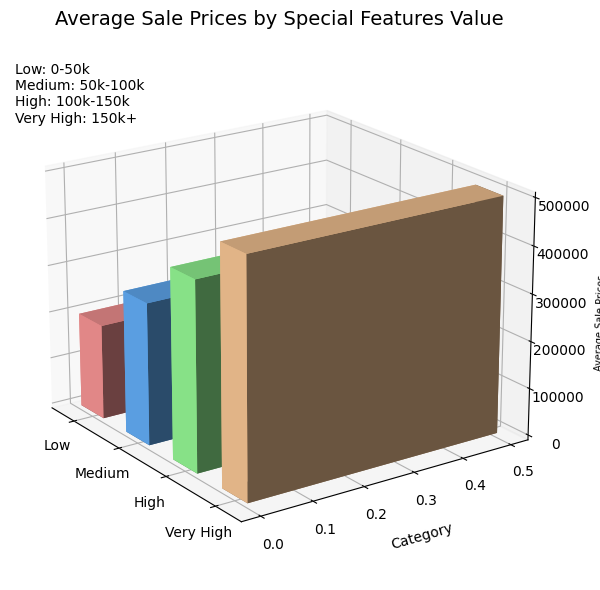

In [50]:
from mpl_toolkits.mplot3d import Axes3D
# Create a 3D bar chart with proper spacing and readable labels
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# Define the range and width of the bars
x_pos = np.arange(data['Feature_Value_Category'].nunique())
bar_width = 0.5

# Plot the bars
for i, (cat, val) in enumerate(zip(categories, avg_sale_prices)):
    ax.bar3d(i, 0, 0, bar_width, bar_width, val, color=colors[i])

# Set the labels and title with spacing adjustments
ax.set_title('Average Sale Prices by Special Features Value', fontsize=14, pad=12)
ax.set_ylabel('Category', fontsize=10, labelpad=10)
ax.set_zlabel('Average Sale Prices', fontsize=7, labelpad=7)

# Set the x-ticks to be at the center of the bars and correspond to the category names
ax.set_xticks(x_pos + bar_width / 2)
ax.set_xticklabels(categories)

# Adjust viewing angle for better visualization
ax.view_init(elev=20, azim=-35)

# Add a legend or a description in the plot to explain the categories
ax.text2D(0.01, 0.85, "Low: 0-50k\nMedium: 50k-100k\nHigh: 100k-150k\nVery High: 150k+", transform=ax.transAxes)

# Add a tight layout to adjust the subplot parameters
plt.tight_layout()

# Show the plot
plt.show()


In [25]:
!pip install folium


In [26]:
import folium

# Miami, FL coordinates
miami_coordinates = [25.7617, -80.1918]

# Create a map of Miami
miami_map = folium.Map(location=miami_coordinates, zoom_start=12)  # Adjust zoom_start as needed

# Assuming 'data' is your DataFrame and contains 'LATITUDE', 'LONGITUDE', and 'structure_quality' columns
for idx, row in data.iterrows():
    # Filter for properties within Miami coordinates and with structure quality of 3
    if (25.7 < row['LATITUDE'] < 25.9 and -80.3 < row['LONGITUDE'] < -80.1) and row['structure_quality'] == 2:
        folium.Marker([row['LATITUDE'], row['LONGITUDE']],
                      popup=f"Price: ${row['SALE_PRC']:.2f}, SqFt: {row['TOT_LVG_AREA']}").add_to(miami_map)

# Display the map
miami_map



By creating a map with specific property information, especially focusing on properties with a structure quality of 3, can be highly beneficial for a variety of stakeholders, including potential homebuyers, investors, and real estate professionals who are interested in the Miami real estate market. Here’s how such a map can assist a person in different form:
1. Homebuyers

    Location Scouting: The map can help potential homebuyers visually identify where homes rated with a structure quality of 3 are predominantly located within Miami. This aids in narrowing down neighborhoods based on the quality of housing they are interested in.
    Price Comparison: By viewing the sale prices on the map, homebuyers can compare costs across different areas directly, helping them to find homes within their budget in preferred locations.
    Decision Making: The combination of visual location data, price information, and structure quality can guide homebuyers in making more informed decisions about where to purchase a property.

2. Real Estate Investors

    Market Analysis: Investors can use the map to analyze market trends, such as which areas have a concentration of medium-quality homes ( structure quality can be filtered out 1-5) and whether these areas are appreciating in value.
    Strategic Investments: The map allows investors to identify potential investment opportunities, focusing on properties that might yield a good return on investment based on their location and inherent property qualities.
    Comparative Analysis: By examining properties on a geographical basis, investors can perform a comparative analysis to pinpoint areas with the highest potential for rental income or resale value.

3. Real Estate Agents

    Listing Presentations: Agents can use the map during presentations to show clients where available properties are located and how they compare to others in terms of price and quality.
    Marketing Tool: Real estate agents can also use the map as a marketing tool to highlight their knowledge of the market, showcasing properties that align with the needs and preferences of their clients.
    Neighborhood Insights: Agents can provide potential buyers with insights into different neighborhoods’ characteristics, leveraging the localized data from the map to enhance their consultancy.



# Limitations Encountered:

Price Appreciation Rates: Can't be calculated without historical data across multiple years. Inventory Levels: Can't be assessed without data on current listings or sales over different time periods.

Cost-Benefit Analyses: Challenging without explicit cost data for properties and future appreciation projections.

User Feedback and Market Research: Requires additional survey data or market reports